In [1]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import norm
import pandahouse as ph

# Вариант 2

# Задание 1. A/B–тестирование

### Загружаем данные

In [3]:
# Загружаем данные
# ссылки на файлы
groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
#Функция для получения загрузочной ссылки c диска
def get_yandex_download_url(public_key):
    'Функция для получения загрузочной ссылки c диска'
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url
groups = pd.read_csv(get_yandex_download_url(groups),sep=';')
groups_add = pd.read_csv(get_yandex_download_url(groups_add),sep=',')
active_studs = pd.read_csv(get_yandex_download_url(active_studs),sep=',')
checks = pd.read_csv(get_yandex_download_url(checks),sep=';')

In [2]:
# groups = pd.read_csv('groups.csv',sep=';')
# groups_add = pd.read_csv('groups_add.csv',sep=',')
# active_studs = pd.read_csv('active_studs.csv',sep=',')
# checks = pd.read_csv('checks.csv',sep=';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
groups.duplicated().sum()

0

In [7]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [8]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [9]:
groups_add.duplicated().sum()

0

In [10]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [12]:
active_studs.duplicated().sum()

0

In [13]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [14]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [ ]:
checks.duplicated().sum()

### 1.3 Вопросы

####    1. На какие метрики Вы смотрите в ходе анализа и почему?

###### Обьеденим данные тех кто участвовал в тесте заходил в приложение и делал оплаты 

In [9]:
df_data = groups.append(groups_add, ignore_index=True)
df_data = pd.merge(df_data, active_studs,how='left', left_on='id', right_on = 'student_id')
df_data = pd.merge(df_data, checks, how='left',on = 'student_id')
# пропуски где нет оплат меняем на 0
df_data = df_data[df_data['student_id'].isna()==False]
df_data.rev.fillna(0, inplace=True)

In [19]:
df_data.head()

,id,grp,student_id,rev
1,1627,A,1627.0,990.0
10,2085,B,2085.0,0.0
12,2215,B,2215.0,0.0
43,3391,A,3391.0,0.0
45,3401,B,3401.0,0.0


In [20]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 1 to 74562
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8341 non-null   int64  
 1   grp         8341 non-null   object 
 2   student_id  8341 non-null   float64
 3   rev         8341 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 325.8+ KB


In [21]:
df_data.duplicated().sum()

0

In [24]:
df_data.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


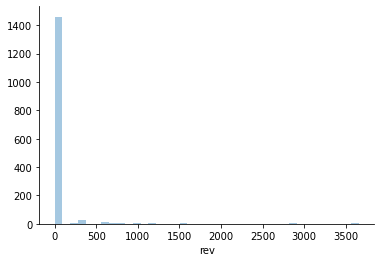

In [52]:
sns.distplot(df_data.query('grp =="A"').rev, kde=False)
sns.despine()

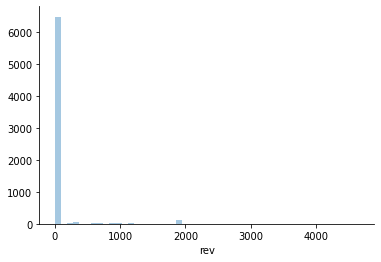

In [27]:
sns.distplot(df_data.query('grp =="B"').rev, kde=False)
sns.despine()

### Будем использовать следующие метрики:
CR (конверсия в покупку) - отношение количества оплативших клиентов к числу посетивших приложение.

ARPU - отношение общей суммы платежей на количество пользователей зашедших в приложение. 

ARPPU - отношение общей суммы платежей на количество активных платящих пользователей. 

###    2. Имеются ли различия в показателях и с чем они могут быть связаны?

###### напишем функцию для расчеиа метрик

In [22]:
def get_metrics(df):
    'функция для расчета метрик cr arpu arppu'
    count_a = df.query('grp =="A"').id.count()
    count_b = df.query('grp =="B"').id.count()
    cr_a = round((100 *df.query('grp =="A"').query('rev > 0').rev.count()/df.query('grp =="A"').shape[0]),4)
    cr_b = round((100 *df.query('grp =="B"').query('rev > 0').rev.count()/df.query('grp =="B"').shape[0]),4)
    arpu_a = round((df.query('grp =="A"').rev.mean()),4)
    arpu_b = round((df.query('grp =="B"').rev.mean()),4)
    arppu_a = round((df.query('grp =="A"').rev.sum()/df.query('grp =="A"').query('rev > 0').rev.count()),4)
    arppu_b = round((df.query('grp =="B"').rev.sum()/df.query('grp =="B"').query('rev > 0').rev.count()),4)    
    metrics = pd.DataFrame([['A',count_a, cr_a, arpu_a, arppu_a], 
                            ['B',count_b, cr_b, arpu_b, arppu_b]], 
                           columns=['group', 'count_ids','cr','arpu', 'arppu'])
    
    return(metrics)

### расчитаем метрики

In [23]:
metrics = get_metrics(df_data)
metrics

,group,count_ids,cr,arpu,arppu
0,A,1538,5.0715,47.3472,933.5897
1,B,6803,4.6156,58.0588,1257.8790


##### смотрим на распределение платежей в группах

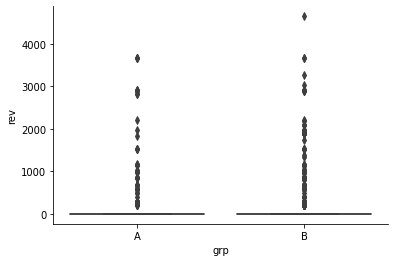

In [53]:
sns.boxplot(data=df_data, y='rev', x='grp')
sns.despine()

##### большинство платежей 0 посмотрим  на распределение платежей > 0 в группах

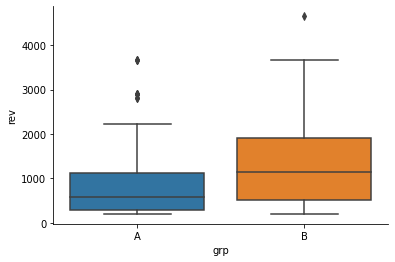

In [56]:
sns.boxplot(data=df_data.query('rev >0'), y='rev', x='grp')
sns.despine()

### Конверсия(CR) в покупки в тестовой группе стала меньше(это не очень хорошо), но ARPU, ARPPU увеличилось(это хорошо для бизнеса) это значит увеличился средний чек, но  возможно появились какието тех.трудности с оплатой.

### 3. Являются ли эти различия статистически значимыми?

### Применим метод Bootstrap( он позволит сбалансировать наши выборки), так как размеры групп очень сильно отличаются, поэтому классические тесты могут давать большие погрешности

### Сравним средние значения наших метрик
- Нулевая Гипотеза **H0**: Средние значения **'cr','arpu', 'arppu'** в двух группах не различаются
- Альтенативная Гипотеза **H1**: Средние значения **'cr','arpu', 'arppu'** различаются

In [12]:
def get_bootstrap(
    data_column_1, #  1 группа
    data_column_2, # 2 группа
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика 
    bootstrap_conf_level = 0.95 # уровень значимости
):
    'функция метода Бутстрап'
    boot_data = []
    boot_len  = max([len(data_column_1), len(data_column_2)])
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### Создадим функции для Бутстрапа

In [13]:
# Подкорректируем функции для бутстрапа
def cr(x):
    'расчет CR'
    return (len([i for i in x if i>0]) / len(x))
def arpu(x):
    'расчет ARPU'
    return np.mean(x)

def arppu(x):
    'расчет ARPPU'
    return np.sum(x) / len([i for i in x if i>0]) 


### Бутстрап по CR

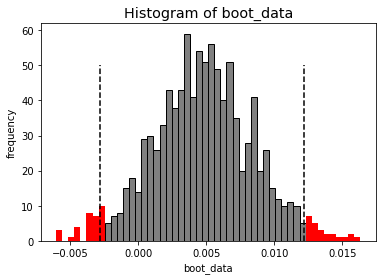

In [14]:
booted_cr = get_bootstrap(df_data.query('grp =="A"').rev, df_data.query('grp =="B"').rev, statistic=cr)

In [15]:
booted_cr['p_value']

0.19663899028301346

##### Вывод по бутстрапу (CR):
CR в тестовой и контрольной группах не различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал попадает нулевое значение разницы между CR двух групп.

**p-value > 0.05** говорит о том, что при условии верности нулевой гипотезы о равенстве CR в двух группах вероятность получить такое или еще большее отклонение разницы от 0 составляет более 5%. То есть полученная нами разница не оказалась бы редким явлением, если бы CR двух групп на самом деле были равны. Значит, мы не имеем весомых оснований отвергнуть нулевую гипотезу и остаемся в ее рамках.

Полученная нами разница - это средняя разница между CR бутстрап-выборок.

### Бустрап по ARPU

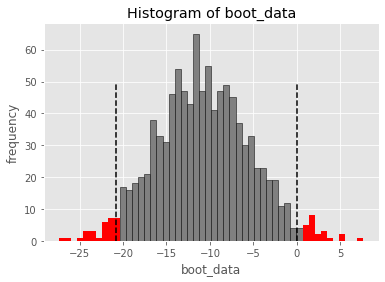

In [16]:
booted_arpu = get_bootstrap(df_data.query('grp =="A"').rev, df_data.query('grp =="B"').rev, statistic=arpu)

In [17]:
booted_arpu["p_value"]

0.04320308227428901

##### Вывод по бутстрапу  (ARPU):
ARPU в тестовой и контрольной группах различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал не попадает нулевое значение разницы между двумя средними.

p-value < 0.05 говорит о том, что при условии верности нулевой гипотезы о равенстве средних в двух группах вероятность получить такое или еще большее отклонение разницы от 0 составляет менее 5%.

То есть полученная нами разница оказалась бы достаточно редким явлением, если бы средние двух групп на самом деле были равны.

Значит, мы имеем основание отвергнуть нулевую гипотезу в пользу альтернативной.

Полученная нами разница - это средняя разница между средними значениями бутстрап-выборок.

### Бутстрап по ARPPU

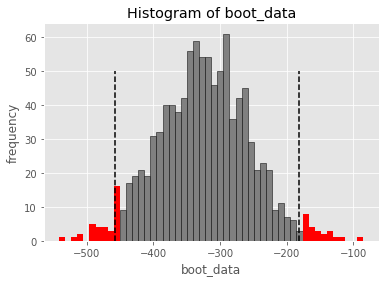

In [18]:
booted_arppu = get_bootstrap(df_data.query('grp =="A"').rev, df_data.query('grp =="B"').rev, statistic=arppu) 

In [19]:
booted_arppu["p_value"]

2.13405754926056e-06

##### Вывод по бутстрапу (ARPPU):
ARPPU в тестовой и контрольной группах различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал не попадает нулевое значение разницы между двумя средними.

p-value < 0.05 говорит о том, что при условии верности нулевой гипотезы о равенстве ARPPU в двух группах вероятность получить такое или еще большее отклонение разницы от 0 составляет менее 5%.

То есть полученная нами разница оказалась бы достаточно редким явлением, если бы средние двух групп на самом деле были равны.

Значит, мы имеем основание отвергнуть нулевую гипотезу в пользу альтернативной.

Полученная нами разница -  это средняя разница между ARPPU  бутстрап-выборок.

## Различия в группах  по ARPU и ARPPU статистически значимы по CR различия статистически не значимы

### 4. Стоит ли запускать новую механику на всех пользователей?

## Мы имеем статистически значимые различия в пользу увелечения среднего чека и на покупателя и на пользователя, причем CR статистически значимо не различаются, мы имеем все основания отвергнуть "0" гипотезу для   ARPU и ARPPU. 
# Стоить  запустить новую механику на всех

# Задание 2. SQL
## 2.1 Очень усердные ученики.
### 2.1.1 Условие
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

###### Подключаемся к Clickhouse

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

###### Создаем запрос

In [43]:
# создаем запрос
q = '''
    SELECT COUNT(st_id) AS number_of_diligent
    FROM
    (SELECT  st_id ,toStartOfMonth(timest) AS month, SUM( correct ) AS all_sum
    FROM default.peas
    GROUP BY  st_id, month)
    WHERE  all_sum >19 AND month = (SELECT MAX(toStartOfMonth(timest))  FROM default.peas)
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
test_1 = ph.read_clickhouse(query=q, connection=connection_default)
test_1

,number_of_diligent
0,136


## 2.2 Оптимизация воронки
### 2.2.1 Условие
Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача


Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

    ARPU 
    ARPAU 
    CR в покупку 
    СR активного пользователя в покупку 
    CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.


###### Создаем запрос

In [4]:
q = '''
   SELECT sum(money) / count (distinct(st_id)) as arpu, 
    sum(CASE WHEN activ = 1 THEN money ELSE 0 END) / count(distinct(CASE WHEN activ = 1 THEN st_id END)) AS arpau,
    count(distinct(CASE WHEN is_pay = 1 THEN st_id END)) / count (distinct(st_id)) as cr, 
    count(distinct(CASE WHEN is_pay = 1 and activ = 1 THEN st_id END))/count(distinct(CASE WHEN  activ = 1 THEN st_id END)) as cr_activ,
    count(distinct(CASE WHEN is_pay = 1 and activ_math = 1 and subject = 'Math' THEN st_id END))/count(distinct(CASE WHEN  activ_math = 1 THEN st_id END)) as cr_activ_math
FROM default.studs z1
LEFT JOIN
(SELECT distinct (st_id),subject, money,count_cor_all,count_cor_math,(CASE WHEN money > 0 THEN 1 ELSE 0 END) as is_pay,
    (CASE WHEN count_cor_math > 2 THEN 1 ELSE 0 END) as activ_math,  (CASE WHEN count_cor_all> 10 THEN 1 ELSE 0 END) activ
FROM 
    (SELECT distinct (st_id), subject, money
            FROM default.final_project_check)t1
    FULL JOIN        
    (SELECT st_id, count_cor_all,count_cor_math
       
    FROM
        (SELECT  distinct(st_id),  SUM(correct) AS count_cor_all, 
        SUM(CASE WHEN peas.subject = 'Math' THEN peas.correct ELSE 0 END) as count_cor_math
        FROM default.peas
        GROUP BY  st_id))t2
    USING(st_id))z2
USING(st_id)
GROUP BY test_grp
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test_2 = ph.read_clickhouse(query=q, connection=connection_default)
q_test_2

,arpu,arpau,cr,cr_activ,cr_activ_math
0,4540.983607,10393.700787,0.049180,0.110236,0.061224
1,11508.474576,29739.583333,0.108475,0.260417,0.095238


## Задание 3. Python
### 3.1 Задача
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла **groups_add.csv** (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики. 

In [26]:
def get_yandex_download_url(public_key):
    'Функция для получения загрузочной ссылки c диска'
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

def get_metrics(df):
    'функция для расчета метрик cr arpu arppu'
    count_a = df.query('grp =="A"').id.count()
    count_b = df.query('grp =="B"').id.count()
    cr_a = round((100 *df.query('grp =="A"').query('rev > 0').rev.count()/df.query('grp =="A"').shape[0]),4)
    cr_b = round((100 *df.query('grp =="B"').query('rev > 0').rev.count()/df.query('grp =="B"').shape[0]),4)
    arpu_a = round((df.query('grp =="A"').rev.mean()),4)
    arpu_b = round((df.query('grp =="B"').rev.mean()),4)
    arppu_a = round((df.query('grp =="A"').rev.sum()/df.query('grp =="A"').query('rev > 0').rev.count()),4)
    arppu_b = round((df.query('grp =="B"').rev.sum()/df.query('grp =="B"').query('rev > 0').rev.count()),4)    
    metrics = pd.DataFrame([['A',count_a, cr_a, arpu_a, arppu_a], 
                            ['B',count_b, cr_b, arpu_b, arppu_b]], 
                           columns=['group', 'count_ids','cr','arpu', 'arppu'])
    
    return(metrics)

def add_data(groups_add_link, groups=groups,checks=checks,active_studs=active_studs):
    '''
    функция для пересчета метрик на основе вновь поступивших данных
    groups_add_link - ссылка на новый файл groups_add
    groups - существующий дата фрейм(в который надо добавть данные)
    checks- датафрейм с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
    active_studs- датафрейм с информацией об оплатах пользователей в дни проведения эксперимента.
    фунция возвращает датафрейм метрик 2х груп
    функция get_yandex_download_url должна быть уже обьявлена ранее
    функция get_metrics должна быть уже обьявлена ранее
    '''

    get_metrics
    # скачиваем дополнительный файл
    # функция get_yandex_download_url уже обьявлена ранее
    groups_add = pd.read_csv(get_yandex_download_url(groups_add_link),sep=',')
    # повторим все шаги из 1 задания
    # соединяем данные 
    df = groups.append(groups_add, ignore_index=True)
    df = pd.merge(df, active_studs,how='left', left_on='id', right_on = 'student_id')
    df = pd.merge(df, checks, how='left',on = 'student_id')
    # пропуски где нет оплат меняем на 0
    df = df[df['student_id'].isna()==False]
    df.rev.fillna(0, inplace=True)
    # расчитываем метрики
    metrics = get_metrics(df)    
    return(metrics)

In [27]:
# ссылка на ЯндексДиск где новый файл groups_add.csv
groups_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

full_data = add_data(groups_add_link)
full_data

,group,count_ids,cr,arpu,arppu
0,A,1538,5.0715,47.3472,933.5897
1,B,6803,4.6156,58.0588,1257.8790


### Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [38]:
def build_graphs(metrics):
    'функция принимает датафрейм с метриками из функции add_data  и рисует графики'
    fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize = (16, 6)) 

    sns.barplot(y='cr', x="group", data=metrics, ax=axs[0]).set_title('CR')
    sns.barplot(y='arpu', x="group", data=metrics, ax=axs[1]).set_title('ARPU')
    sns.barplot(y='arppu', x="group", data=metrics, ax=axs[2]).set_title('ARPU')


    plt.show()

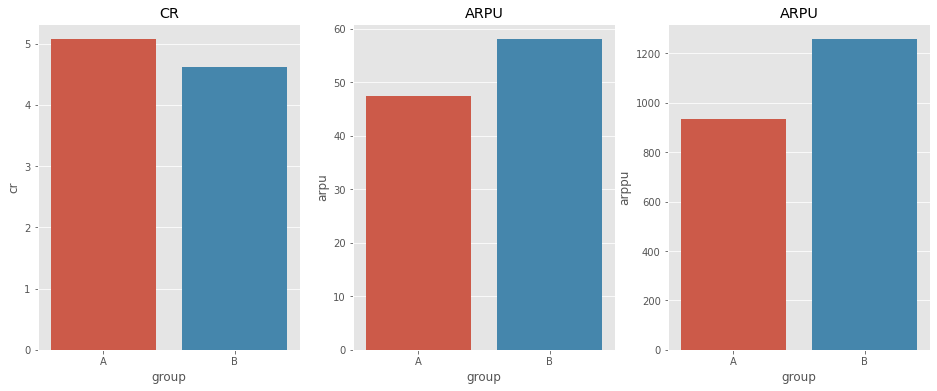

In [39]:
build_graphs(full_data)